# Information

## Column information

* The vessel's Maritime Mobile Service Identity (MMSI) – a unique nine digit identification number.
* Navigation status – "at anchor", "under way using engine(s)", "not under command", etc.
* Rate of turn – right or left, from 0 to 720 degrees per minute
* Speed over ground – 0.1-knot (0.19 km/h) resolution from 0 to 102 knots (189 km/h)
* Positional accuracy:
* Longitude – to 0.0001 minutes
* Latitude – to 0.0001 minutes
* Course over ground – relative to true north to 0.1°
* True heading – 0 to 359 degrees (for example from a gyro compass)
* True bearing at own position. 0 to 359 degrees
* UTC Seconds – The seconds field of the UTC time when these data were generated. A complete timestamp is not present.


In addition, the following data are broadcast every 6 minutes:

* IMO ship identification number – a seven digit number that remains unchanged upon transfer of the ship's registration to another country
* Radio call sign – international radio call sign, up to seven characters, assigned to the vessel by its country of registry
* Name – 20 characters to represent the name of the vessel
* Type of ship/cargo
* Dimensions of ship – to nearest meter
* Location of positioning system's (e.g., GPS) antenna on board the vessel - in meters aft of bow and meters port or starboard
* Type of positioning system – such as GPS, DGPS or LORAN-C.
* Draught of ship – 0.1 meter to 25.5 meters
* Destination – max. 20 characters
* ETA (estimated time of arrival) at destination – UTC month/date hour:minute
* optional : high precision time request, a vessel can request other vessels provide a high precision UTC time and datestamp


# Initialization

In [64]:
import numpy as np
import pandas as pd
from surprise import SVD, Dataset,Reader
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d, splev, splrep 
import geopandas as gpd
import datetime, time
from shapely.geometry import LineString
import folium
%matplotlib inline

from os import path, getcwd
from glob import glob

In [65]:
def removeLatLon(dataset,lat=80,lon=-100):
    dataset= dataset.loc[dataset.Latitude<lat]
    dataset= dataset.loc[dataset.Longitude<lon]
    return dataset

In [216]:
#this function get the data of a ship with userID on a given day and return the data
#@param 
# uid (string): ship uuid
# data (panda.dataFrame): the data to use(e.g current or hist)

def oneDayData(data,uid,day,month=10,year=2013,):
    
    df = data.loc[data['ReceivedDate'] == datetime.date(year,month,day),:]
    df=df.loc[df.UserID==uid,:]
    df.sort_values(by=['ReceivedTime'])
    return df

In [75]:
# this function use culic spline to interpolate a path of a given ship on a day and 
# return 10000 equally spaced interploated points 
# @param data(panda.dataFrame): the data you get from call oneDayData


def interpolate(data,npoint):
    
    try: 
        timeArr = data.ReceivedTime.dt.to_pydatetime()
        timeArrSeconds = []
        t0=time.mktime(timeArr[0].timetuple())

        for t in timeArr:
            timeArrSeconds.append(time.mktime(t.timetuple())-t0)

        x = data['Longitude']
        f = interp1d(timeArrSeconds, x, kind='cubic')
        y = data['Latitude']
        f2 = interp1d(timeArrSeconds, y, kind='cubic')
    except:
#         print('this path is not valid')
        return None
        
    t2=np.linspace(timeArrSeconds[0],timeArrSeconds[len(timeArrSeconds)-1],npoint)    
    retval=pd.DataFrame(data={'lat':f2(t2),'lon':f(t2)})
    return retval

In [69]:
code_dir = getcwd()
data_dir = path.expanduser('~/data/workshop-content18/3-snc/data/')


ais_pathnames = glob(data_dir + '*.txt')
ais_basenames = [path.basename(pn) for pn in ais_pathnames]
for bn in ais_basenames:
    print(bn)

!ls -l {data_dir}


delta_cur_basename = next(bn for bn in ais_basenames if 'Deltaport_Current' in bn)
delta_his_basename = next(bn for bn in ais_basenames if 'Deltaport_History' in bn)
nw_cur_basename = next(bn for bn in ais_basenames if 'NewWestminster_Current' in bn)
nw_his_basename = next(bn for bn in ais_basenames if 'NewWestminster_History' in bn)


max_rows=int(3e6)
delta_cur = pd.read_csv(
    data_dir + delta_cur_basename, sep='\t', nrows=max_rows, low_memory=False,
    parse_dates=['ReceivedTime'])
delta_his = pd.read_csv(
    data_dir + delta_his_basename, sep='\t', nrows=max_rows, low_memory=False,
    parse_dates=['ReceivedTime'])
nw_cur = pd.read_csv(
    data_dir + nw_cur_basename, sep='\t', nrows=max_rows, low_memory=False,
    parse_dates=['ReceivedTime'])
nw_his = pd.read_csv(
    data_dir + nw_his_basename, sep='\t', nrows=max_rows, low_memory=False,
    parse_dates=['ReceivedTime'])



if delta_cur.isna().iloc[-1,:].sum() > 10:
    delta_cur = delta_cur.iloc[:-1, :]
    
if delta_his.isna().iloc[-1,:].sum() > 10:
    delta_his = delta_his.iloc[:-1, :]
    
if nw_cur.isna().iloc[-1,:].sum() > 10:
    nw_cur = nw_cur.iloc[:-1, :]
    

if nw_his.isna().iloc[-1,:].sum() > 10:
    nw_his = nw_his.iloc[:-1, :]


delta_cur.UserID = delta_cur.UserID.astype('category')

UserID_ValueCounts = pd.value_counts(delta_cur.UserID)
UserID_ValueCounts.loc[UserID_ValueCounts < 1000].values.sum()

delta_cur = removeLatLon(delta_cur)
delta_his = removeLatLon(delta_his)
nw_cur = removeLatLon(nw_cur)
nw_his = removeLatLon(nw_his)


nPoints_by_UserID = pd.value_counts(delta_cur.UserID)
nPoints_threshold = 1000
print('num rows for which userid count <= 1000:', nPoints_by_UserID.loc[nPoints_by_UserID <= 1000].values.sum())
userID_allowed = nPoints_by_UserID.index[nPoints_by_UserID > nPoints_threshold]

delta_cur = delta_cur.loc[delta_cur.UserID.apply(lambda x: x in userID_allowed.values)]

ReceivedDate = delta_cur.ReceivedTime.dt.date
ReceivedDate_ValueCounts = pd.value_counts(ReceivedDate)
ReceivedDate_ValueCounts.to_frame()
delta_cur['ReceivedDate'] =ReceivedDate
delta_cur['ReceivedDay'] = ReceivedDate.apply(lambda x: x.day)

ReceivedDate = delta_his.ReceivedTime.dt.date
ReceivedDate_ValueCounts = pd.value_counts(ReceivedDate)
ReceivedDate_ValueCounts.to_frame()
delta_his['ReceivedDate'] =ReceivedDate
delta_his['ReceivedDay'] = ReceivedDate.apply(lambda x: x.day)

ReceivedDate = nw_cur.ReceivedTime.dt.date
ReceivedDate_ValueCounts = pd.value_counts(ReceivedDate)
ReceivedDate_ValueCounts.to_frame()
nw_cur['ReceivedDate'] =ReceivedDate
nw_cur['ReceivedDay'] = ReceivedDate.apply(lambda x: x.day)

ReceivedDate = nw_his.ReceivedTime.dt.date
ReceivedDate_ValueCounts = pd.value_counts(ReceivedDate)
ReceivedDate_ValueCounts.to_frame()
nw_his['ReceivedDate'] =ReceivedDate
nw_his['ReceivedDay'] = ReceivedDate.apply(lambda x: x.day)


PMV_AIS_NewWestminster_Current.txt
PMV_AIS_Deltaport_Current.txt
PMV_AIS_Deltaport_History.txt
PMV_AIS_NewWestminster_History.txt
total 1443544
-rw-rw-r--. 1 jovyan 1000 277236490 Jul 29  2015 PMV_AIS_Deltaport_Current.txt
-rw-rw-r--. 1 jovyan 1000 246584377 Jul 29  2015 PMV_AIS_Deltaport_History.txt
-rw-r--r--. 1 jovyan 1000 244538069 Apr 16 20:37 PMV_AIS_Files.zip
-rw-rw-r--. 1 jovyan 1000 412480776 Jul 29  2015 PMV_AIS_NewWestminster_Current.txt
-rw-rw-r--. 1 jovyan 1000 296033832 Jul 29  2015 PMV_AIS_NewWestminster_History.txt
num rows for which userid count <= 1000: 48843


,UserID,NavigationalStatus,ROT,SOG,PositionAccuracy,Longitude,Latitude,COG,TrueHeading,TimeStamp,ReceivedTime,rowid,ReceivedDate,ReceivedDay
0,373787000,1.0,0.0,0.0,1.0,-123.20450,49.29432,31.6,350.0,3.0,2013-08-01 00:00:04.547,635755721.0,2013-08-01,1
1,353785000,5.0,0.0,0.0,1.0,-123.07653,49.28967,214.0,107.0,8.0,2013-08-01 00:00:10.747,635755748.0,2013-08-01,1
2,538004628,5.0,0.0,0.0,1.0,-122.86830,49.29035,354.0,321.0,35.0,2013-08-01 00:00:37.937,635755869.0,2013-08-01,1
3,316009547,5.0,0.0,0.0,0.0,-123.67887,48.98024,173.0,210.0,59.0,2013-08-01 00:01:00.140,635755975.0,2013-08-01,1
4,316020067,15.0,-127.0,0.0,0.0,-122.96179,49.15462,301.3,511.0,1.0,2013-08-01 00:01:00.483,635755976.0,2013-08-01,1


In [14]:
def headsNorTails(dfs):
    """
    cheekily named function for viewing the head and the tail of the data
    """
    dfs = pd.concat((dfs.head(), dfs.tail()))
    if isinstance(dfs, pd.Series):
        dfs = dfs.to_frame()
    return dfs



,UserID
316014995,70580
316004702,70119
316005727,68144
316023452,64002
316020869,56165
338616000,1
239730000,1
367474610,1
351468288,1
986710691,1


Total number of rows corresponding to `UserID`s having fewer than 1000 data points:

48856

**Look at Lon-Lat values**

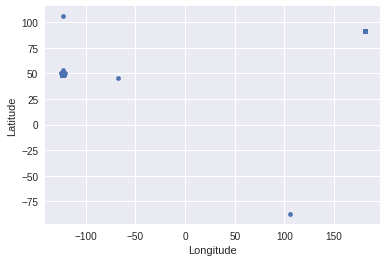

In [15]:
delta_cur.plot.scatter('Longitude', 'Latitude');

There's this many points that are broadcasting from the North Pole:

In [16]:
(delta_cur.Latitude > 80).sum()

57772

Let's get rid of them because they don't belong in the Vancouver harbour — who knows what else is 'off' with them

<div class="alert alert-block alert-info">
**Note:** get rid of `UserID`s that only appear once — I doubt we can do anything with these.
</div>

In [218]:
d1=oneDayData(delta_cur,'316005621',22)


num rows for which userid count <= 1000: 0


In [55]:
userID_allowed.values.remove_unused_categories(inplace=True)

AttributeError: 'numpy.ndarray' object has no attribute 'remove_unused_categories'

**Checking plot again**

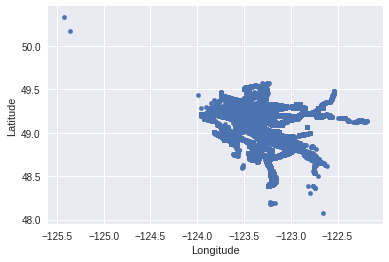

In [42]:
delta_cur.plot.scatter('Longitude', 'Latitude');

**Format dates**

In [43]:
ReceivedDate = delta_cur.ReceivedTime.dt.date
ReceivedDate_ValueCounts = pd.value_counts(ReceivedDate)
ReceivedDate_ValueCounts.to_frame()
delta_cur['ReceivedDate'] =ReceivedDate
delta_cur['ReceivedDay'] = ReceivedDate.apply(lambda x: x.day)

ReceivedDate = delta_his.ReceivedTime.dt.date
ReceivedDate_ValueCounts = pd.value_counts(ReceivedDate)
ReceivedDate_ValueCounts.to_frame()
delta_his['ReceivedDate'] =ReceivedDate
delta_his['ReceivedDay'] = ReceivedDate.apply(lambda x: x.day)

ReceivedDate = nw_cur.ReceivedTime.dt.date
ReceivedDate_ValueCounts = pd.value_counts(ReceivedDate)
ReceivedDate_ValueCounts.to_frame()
nw_cur['ReceivedDate'] =ReceivedDate
nw_cur['ReceivedDay'] = ReceivedDate.apply(lambda x: x.day)

ReceivedDate = nw_his.ReceivedTime.dt.date
ReceivedDate_ValueCounts = pd.value_counts(ReceivedDate)
ReceivedDate_ValueCounts.to_frame()
nw_his['ReceivedDate'] =ReceivedDate
nw_his['ReceivedDay'] = ReceivedDate.apply(lambda x: x.day)


AttributeError: 'float' object has no attribute 'day'

In [ ]:
del

In [ ]:
delta_cur['UserID'].describe()

Next we'd really like to know about the distributions of how many records are sent for each ship on each day. To do this, let's count the number of records on each ship on each day and then make a swarm plot / violin plot / box plot for each day where there are recording. We expect right-skew, and hope that the results suggest some kind of "natural cut-off" value - we can select all UserIDs with a sufficiently high number of records and maybe just work with those.

In [ ]:
sns.set(style="whitegrid", color_codes=True)

In [ ]:
df_grp = delta_cur.groupby(['ReceivedDay', 'UserID'])

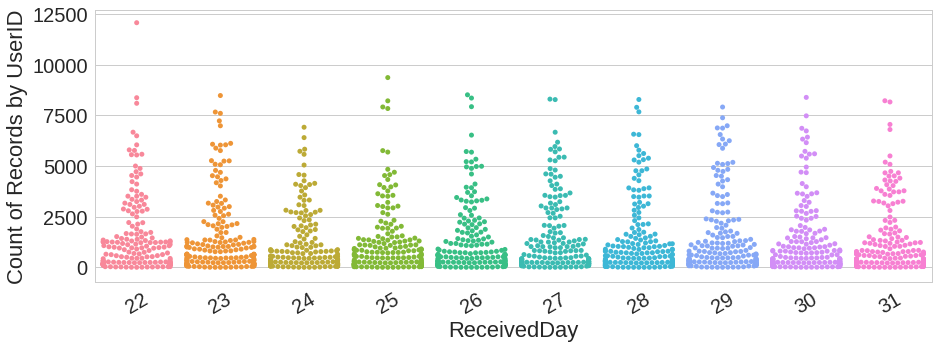

In [28]:
sns.set(style='whitegrid', font_scale=2)
plt.figure(figsize=(15, 5))
ax = sns.swarmplot(
    x='ReceivedDay', y='ROT', 
    data=df_grp['ROT'].count().reset_index())
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_ylabel('Count of Records by UserID');

Great. So for playing around, we could probably look at those UserIDs with only 1500 or more records. 

In [29]:
# code to do that here:



Let's plot records of ships just on the 22nd

Great. After some playing around with axis limits, we can finally see some ship trajectories. There are so many unique ship IDs that I chose not to include a legend. Also, there are some ships with erroneous Lon-Lat readings, which I believe were the cause for me having to play around with the axis limits. 

# To-Do:

* Subset the dataframe to remove any points that have Lon-Lat readings outside of (-127, -120) x (48, 50)
    * (Write code for this and upload it to the repository. We'll eventually have to port this approach to the other data.)
* Subset the dataframe to remove any UserIDs that have fewer than 1000 records
    * (Write code for this and upload it to the repository. We'll eventually have to port this approach to the other data.)
* Group the data by day and for each subgroup, remove any UserIDs that have fewer than ¿10? records
    * (Write code for this and upload it to the repository. We'll eventually have to port this approach to the other data.)
* Make a scatter plot for each day there is recorded data (cf. seaborn.FacetGrid or seaborn.FacetPlot or whatever it is)
    * Make a plot for each day with a **line** for each ship (instead of dots for each ship)
    * Add arrows at each (lon, lat) point denoting the ships heading (see the top of this document for a description pointing you to the relevant column)
    * Save the plot(s) you've made and upload them as pngs to the repository. 
* See if you can find out how to turn the ship's trajectory into a Bezier curve. I've not really played around with Bezier curves, but I know that they could be a useful tool for one possible solution for this project. Basically, each ship trajectory can be represented as an object called a "Bezier curve", all of which can be parametrized by a fixed number of values. This let's us compare ship trajectories by comparing parameter values for the Bezier curves. [This site](http://devmag.org.za/2011/06/23/bzier-path-algorithms/) looks like a great introduction to the idea. 
    * If you have code or images (or better references!) for this, upload it in any format to the repository. We'll need it for the other data / and/or the participants will need to know how to modify the approach to work with the other crazy ideas I have :D

# On a map

Let's take that data above - just the smaller manageable bit - and plot it on a map using `folium` Markers.

In [32]:
# This method generates a path graph of one ship during one .
# It takes the date of the record, the id of the ship and the original pd dataframe
def generateGraphByPlt(date,shipID,data):
    data = oneDayData(date,shipID,data)
    timeArr = data.ReceivedTime.dt.to_pydatetime()
    timeArrSeconds = []


    for t in timeArr:
        timeArrSeconds.append(time.mktime(t.timetuple()))
        lonArr = data.Longitude.values
        latArr = data.Latitude.values
        x = timeArrSeconds
        y1 = lonArr
        y2 = latArr


    tck1 = splrep(x, y1)
    tck2 = splrep(x, y2)

    xnew = np.linspace(x[0],x[len(x) - 1],10000)
    y1new = splev(xnew,tck1)
    y2new = splev(xnew,tck2)

    coastline_x = []
    coastline_y = []

    for shape in geo_data.geometry:
        for point in (shape.coords[:]):
            x,y = point
            coastline_x.append(x)
            coastline_y.append(y)



    plt.figure(figsize=(18,18))
    plt.plot(coastline_x,coastline_y,'o',markersize = 2)
    plt.plot(y1new,y2new,'ro',markersize = 2)
    plt.xlim((-123.5,-122.5))
    plt.ylim((48.75,49.5))


In [33]:
# graph using matplot
generateGraphByPlt(22,'316005621',delta_cur)


NameError: name 'geo_data' is not defined

In [ ]:
# prepare some example data
delta_22_316020869_sparse = (delta_22_316020869
                             .reset_index(drop=True)
                             .iloc[::10, :]
                             .reset_index(drop=True))

In [ ]:

d1=oneDayData(22,'316005621',delta_cur)
d1=interpolate(d1)
d1=d1.values
print(d1)

l1= map(lambda x: tuple(x),d1)
l1=list(l1)

d2=oneDayData(24,'316005621',delta_cur)
d2=interpolate(d2)
d2=d2.values

l2= map(lambda x: tuple(x),d2)
l2=list(l2)







In [ ]:
delta_cur.head()

In [74]:
# importantcell

# add path to matrix

#days=delta_cur.ReceivedDay.unique()
days=delta_cur.ReceivedDay.unique()
#print(days.head())
#uids=delta_cur.UserID.unique()
uids=delta_cur.UserID.unique()
#print(uids.head())

all_path_cur=[]
for day in days:
    for uid in uids:
        d=oneDayData(day,uid,delta_cur)
        path=interpolate(d,1000)
        if (path is not None) :
            lats=path.lat
            lons=path.lon
            lats_rev=lats[::-1]
            lons_rev=lons[::-1]
            row=lats.append(lons)
            row_rev=lats_rev.append(lons_rev)
            all_path_cur.append(row)
            all_path_cur.append(row_rev)
            
            
            

this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path i

this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path i

this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path i

this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path is not valid
this path i

In [ ]:
oneDayData('22','316005621')
plt.plot()

In [76]:
np.save('cur_path_data.txt',all_path_cur)

In [ ]:
np.load('cur_path_data.txt.npy')

In [214]:
delta_cur.head()


,UserID,NavigationalStatus,ROT,SOG,PositionAccuracy,Longitude,Latitude,COG,TrueHeading,TimeStamp,ReceivedTime,rowid,ReceivedDate,ReceivedDay
0,316005621,0.0,-127.0,0.1,0.0,-122.77156,49.23065,32.6,511.0,24.0,2013-10-22 01:05:24.510,311057489.0,2013-10-22,22
1,316018851,0.0,0.0,1.7,0.0,-123.05445,49.29853,67.0,110.0,24.0,2013-10-22 01:05:25.400,311057490.0,2013-10-22,22
2,316003679,2.0,-127.0,0.1,0.0,-123.10751,49.31308,150.8,511.0,24.0,2013-10-22 01:05:25.853,311057491.0,2013-10-22,22
3,316014621,0.0,127.0,12.3,0.0,-123.09534,49.29940,210.7,210.0,26.0,2013-10-22 01:05:26.027,311057492.0,2013-10-22,22
4,316005721,0.0,-127.0,0.1,0.0,-123.10684,49.31094,166.9,511.0,25.0,2013-10-22 01:05:26.620,311057493.0,2013-10-22,22


In [ ]:
oneDayData(8,'316005621',delta_his,2013,8)

In [ ]:
# graph using folium
m = folium.Map(location=[49.23069,-122.77142], 
               tiles='Stamen Terrain', zoom_start=10)
# latlon = zip(delta_22_316020869_sparse.Latitude.values, 
#              delta_22_316020869_sparse.Longitude.values)
# for coord in latlon:
#     folium.Circle(location=coord,fill=True).add_to(m)

folium.PolyLine(l1,color='red').add_to(m)
folium.PolyLine(l2).add_to(m)
m
    

In [42]:
data_raw=np.load('cur_path_data.txt.npy')
data_sup_format=pd.DataFrame()


In [56]:
data_sup_format=pd.DataFrame(columns=['user','item','rating'])
data_raw
n,d=np.shape(data_raw)
[n,d]
point_id=np.linspace(0,d-1,d)
for i in range(0,n):
    path_id=np.zeros([d])+i
    frame_data={'user':path_id,'item':point_id,'rating':data_raw[i]}
    path_frame=pd.DataFrame(data=frame_data)
    data_sup_format=pd.concat([data_sup_format,path_frame])

    
path_id=np.zeros([d])+n

temp=data_raw[n-1]
for i in range(0,d):
    if i%==0:
        temp[i]=0


frame_data={'user':n,'item':point_id,'rating':data_raw[i]}
path_frame=pd.DataFrame(data=frame_data)
data_sup_format=pd.concat([data_sup_format,path_frame])
    

In [73]:
hist_temp=oneDayData(1,'316003664',delta_his,2013,8)


In [74]:
hist_temp

,UserID,NavigationalStatus,ROT,SOG,PositionAccuracy,Longitude,Latitude,COG,TrueHeading,TimeStamp,ReceivedTime,rowid,ReceivedDate,ReceivedDay
0,316003664,3.0,0.0,7.6,0.0,-123.06297,49.13173,218.9,221.0,28.0,2013-08-01 00:00:28.860,288881494.0,2013-08-01,1
77,316003664,3.0,0.0,7.8,0.0,-123.07216,49.12478,221.8,224.0,47.0,2013-08-01 00:04:48.077,288881852.0,2013-08-01,1
148,316003664,3.0,0.0,7.9,0.0,-123.08290,49.11843,234.0,237.0,8.0,2013-08-01 00:09:08.780,288882583.0,2013-08-01,1
234,316003664,3.0,0.0,7.8,0.0,-123.09821,49.11464,253.0,255.0,8.0,2013-08-01 00:14:08.640,288883480.0,2013-08-01,1
316,316003664,3.0,0.0,7.9,0.0,-123.11401,49.11127,252.9,256.0,8.0,2013-08-01 00:19:08.640,288884290.0,2013-08-01,1
398,316003664,3.0,0.0,8.0,0.0,-123.13046,49.10902,264.8,270.0,8.0,2013-08-01 00:24:08.810,288885073.0,2013-08-01,1
480,316003664,3.0,0.0,8.4,0.0,-123.14782,49.10888,272.4,276.0,7.0,2013-08-01 00:29:07.717,288885817.0,2013-08-01,1
553,316003664,3.0,0.0,8.3,0.0,-123.16491,49.11153,290.1,295.0,6.0,2013-08-01 00:34:07.500,288886299.0,2013-08-01,1
622,316003664,3.0,0.0,8.5,0.0,-123.18190,49.11625,293.1,300.0,17.0,2013-08-01 00:39:18.340,288886868.0,2013-08-01,1
700,316003664,3.0,-126.0,8.0,0.0,-123.19699,49.12184,297.8,304.0,14.0,2013-08-01 00:44:14.763,288887563.0,2013-08-01,1


In [65]:
data_sup_format.head()
#data_sup_format.to_csv('./data_sup_format.csv',index=False)
data_sup_format.tail()

reader = Reader(rating_scale=(0,10))

data=Dataset.load_from_df(data_sup_format[['user', 'item', 'rating']],reader)
#data = Dataset.load_from_file('../src/data_sup_format.csv',reader)



In [68]:
from surprise import dump
dump.dump('./temp.txt')

In [ ]:
data_sup_format=pd.DataFrame()
n,d=np.shape(data_raw)
point=np.linspace(0,d,d)


In [ ]:
from sklearn.neighbors import NearestNeighbors

temp = np.asarray(all_path_cur)
np.savetxt('cur_path_data.csv',temp,delimiter=",")
data = np.loadtxt('./cur_path_data.csv',delimiter=",")

In [207]:
data1= np.loadtxt('./cur_path_data.csv',delimiter=",")

In [141]:
from sklearn.metrics import log_loss

def MyMetric(point1,point2):
    return np.log(point1 - point2)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


(48.5, 49.5)

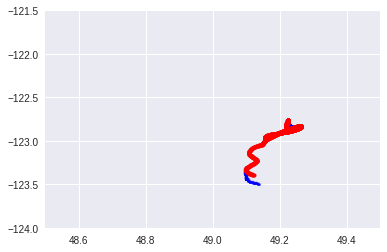

In [414]:
n,d = data.shape
#18 22 40 64 74
#5 indicate the ship stays in the harbor
testidx=800
temp = np.copy(data[testidx,:])

            
n,d = data.shape
train = np.concatenate((data[0:testidx-1,:],data[testidx+1:n-1,:]),axis = 0)
test = data[testidx,:]
#neigh = NearestNeighbors(n_neighbors=,metric)
#neigh = NearestNeighbors(n_neighbors=1)
neigh = NearestNeighbors(n_neighbors=1,metric = "manhattan",algorithm = "brute")
# neigh = NearestNeighbors(n_neighbors=3,metric = "manhattan",algorithm = "brute")


cdist,ind = neigh.kneighbors(test)
arr = np.mean(np.squeeze(train[ind,:], axis=0),axis = 0)

plt.plot(arr[0:999],arr[1000:1999],'b*',data[testidx,0:999],data[testidx,1000:1999],'ro',markersize = 4)
plt.ylim((-124,-121.5))
plt.xlim((48.5,49.5))

(48.5, 49.5)

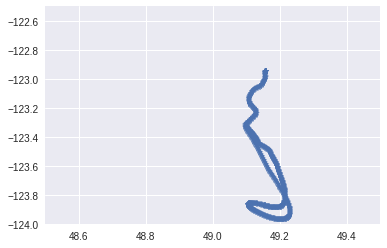

In [408]:
plt.plot(arr[0:999],arr[1000:1999],'*')
plt.ylim((-124,-122.5))
plt.xlim((48.5,49.5))

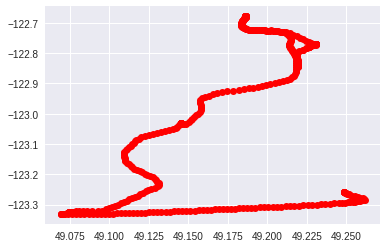

In [180]:
plt.plot(data1[testidx,0:999],data1[testidx,1000:1999],'ro')

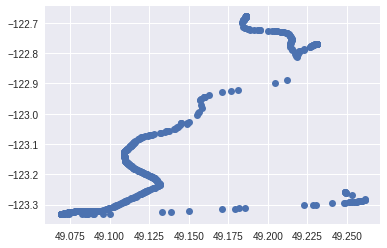

In [221]:
d1
plt.plot(d1.Latitude,d1.Longitude,'o')


In [223]:
p=interpolate(d1,1000)


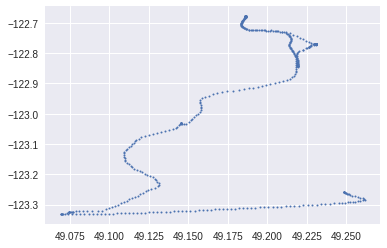

In [227]:
plt.plot(p.lat,p.lon,'o',markersize=2)

In [103]:
[latMean,lonMean]

[49.165683661297699, -123.14388413332402]

In [389]:
data.shape

(2886, 2000)

In [ ]:
n

In [413]:
delta_his

,UserID,NavigationalStatus,ROT,SOG,PositionAccuracy,Longitude,Latitude,COG,TrueHeading,TimeStamp,ReceivedTime,rowid,ReceivedDate,ReceivedDay
0,316003664,3.0,0.0,7.6,0.0,-123.06297,49.13173,218.9,221.0,28.0,2013-08-01 00:00:28.860,288881494.0,2013-08-01,1
1,636092306,1.0,0.0,0.0,0.0,-123.20044,49.30377,74.3,314.0,28.0,2013-08-01 00:00:29.107,288881495.0,2013-08-01,1
2,538005148,0.0,0.0,12.8,1.0,-123.21999,48.56274,168.5,168.0,28.0,2013-08-01 00:00:30.123,288881497.0,2013-08-01,1
3,316005416,0.0,-126.0,3.3,1.0,-123.01252,49.15289,68.2,66.0,29.0,2013-08-01 00:00:30.373,288881498.0,2013-08-01,1
4,316004333,15.0,-127.0,0.0,0.0,-123.16602,49.11944,258.9,511.0,32.0,2013-08-01 00:00:32.640,288881505.0,2013-08-01,1
5,316003349,15.0,-127.0,0.0,0.0,-123.02924,49.29863,331.8,511.0,32.0,2013-08-01 00:00:32.890,288881506.0,2013-08-01,1
6,316003453,0.0,0.0,0.0,0.0,-123.07855,49.20808,284.1,246.0,36.0,2013-08-01 00:00:35.967,288881514.0,2013-08-01,1
7,316023605,0.0,0.0,4.8,0.0,-123.61362,48.89318,187.0,186.0,40.0,2013-08-01 00:00:39.437,288881522.0,2013-08-01,1
8,316005724,0.0,-127.0,1.5,0.0,-123.09968,49.30979,153.8,511.0,38.0,2013-08-01 00:00:40.060,288881523.0,2013-08-01,1
9,316003008,0.0,-127.0,0.1,0.0,-122.97411,49.29052,322.8,511.0,40.0,2013-08-01 00:00:40.280,288881524.0,2013-08-01,1


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


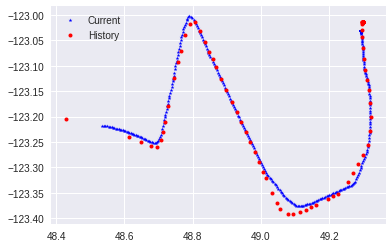

In [526]:
# '316005416',1,8,2013
# neighbor 1 or 2
# 2 4 7 clearly indicate the ship drives along the same path, and history data did not give a very good insight
d_his_test=oneDayData(delta_his,'477165000',1,8,2013)

path=interpolate(d_his_test,1000)
path=np.concatenate((path.lat,path.lon))

neigh = NearestNeighbors(n_neighbors=1,metric = "manhattan",algorithm = "brute")
neigh.fit(train)
dist,ind = neigh.kneighbors(path)
arr = np.mean(np.squeeze(train[ind,:], axis=0),axis = 0)

# plt.plot(arr[0:999],arr[1000:1999],'b*',d_his_test['Latitude'],d_his_test['Longitude'],'ro',markersize = 4)
p1, = plt.plot(arr[0:999],arr[1000:1999],'b*',markersize = 4,label='Current')  
p2, = plt.plot(d_his_test['Latitude'],d_his_test['Longitude'],'ro',markersize = 4,label='History')  

# plt.ylim((-124,-121.5))
# plt.xlim((48.5,49.5))
plt.legend()

(48.5, 49.5)

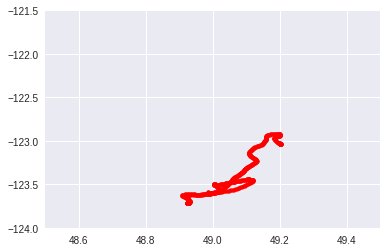

In [505]:
plt.plot(path[0:999],path[1000:1999],'ro',markersize=4)
plt.ylim((-124,-121.5))
plt.xlim((48.5,49.5))

(48.5, 49.5)

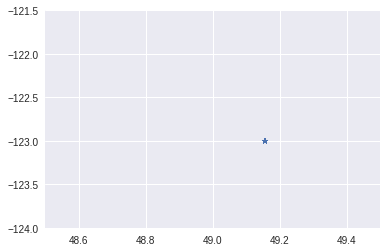

In [438]:
plt.plot(arr[0:999],arr[1000:1999],'*')
plt.ylim((-124,-121.5))
plt.xlim((48.5,49.5))